In [75]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
from scipy.ndimage import rotate
import matplotlib.pyplot as plt

import urllib
from PIL import Image
from torchvision import transforms

from os import listdir
from os.path import isfile, join

use_cuda = False

In [96]:
important_labels = {
    "chihuahua" : 151,
    "shih-tzu": 156,
    "beagle": 162,
    "golden_retriever": 207,
    "labrador_retriever": 208,
    "border_collie": 232,
    "pug": 254,
    "samoyed": 258,
    "pomeranian": 259,
    "toy_poodle": 265,
}

def prep_image(data):
    return rotate(data.T[::-1, :, :], -90)

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [7]:
#References: https://pytorch.org/hub/pytorch_vision_alexnet/
#Dataset: http://vision.stanford.edu/aditya86/ImageNetDogs/

print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

model = torch.hub.load('pytorch/vision:v0.9.0', 'alexnet', pretrained=True)
model.eval()

CUDA Available:  False


Using cache found in /Users/William/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [60]:
### Normal AlexNet

# url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
# try: urllib.URLopener().retrieve(url, filename)
# except: urllib.request.urlretrieve(url, filename)

breed = "golden_retriever"

mypath = "dog/Sample/" + breed + "/"
files = [f for f in listdir(mypath) if (isfile(join(mypath, f)))]
    
probs = []

for filename in files:
    input_image = Image.open(mypath + filename)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    # move the input and model to GPU for speed if available
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model.to('cuda')

    with torch.no_grad():
        output = model(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    #print(output[0])
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    p = torch.nn.functional.softmax(output[0], dim=0)
    probs.append(p)
    #print(p)

with open("../imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
for j in range(len(files)):
    top5_prob, top5_catid = torch.topk(probs[j], 5)
    print(files[j])
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    print("-------------------------------------------------------")

In [97]:
### AlexNet with Fast Gradient Sign Method Attack

#Attack: https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

epsilon = 0.0005 #epsilon controls the power of the adversary; higher epsilon means more power

file = "dog/Sample/golden_retriever/n02099601_4005.jpg"
target = important_labels["golden_retriever"]

input_image = Image.open(file)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

data = input_batch    
data.requires_grad = True

output = model(data)
init_pred = output.max(1, keepdim=True)[1]
init_p = torch.nn.functional.softmax(output[0], dim=0)

loss = F.nll_loss(output, torch.tensor([target]))
model.zero_grad()
loss.backward()
data_grad = data.grad.data
perturbed_data = fgsm_attack(data, epsilon, data_grad)

output = model(perturbed_data)
adv_pred = output.max(1, keepdim=True)[1]
adv_p = torch.nn.functional.softmax(output[0], dim=0)

adv_ex = perturbed_data.squeeze().detach().cpu().numpy()

In [98]:
probs = adv_p

with open("../imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probs, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

shower curtain 0.3060409426689148
paintbrush 0.041130419820547104
tray 0.029230397194623947
apron 0.026142053306102753
book jacket 0.019243521615862846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


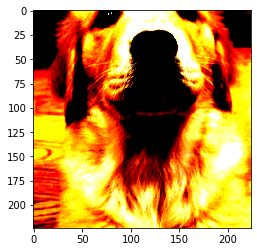

In [99]:
plt.figure()
plt.imshow(prep_image(input_tensor.detach().cpu().numpy()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


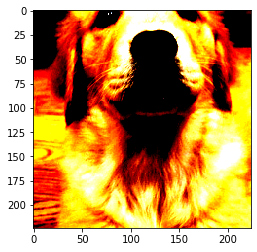

In [104]:
plt.figure()
plt.imshow(prep_image(adv_ex))